# Ex 2 - Transfer learning
##### Group: 9
###### Student 1: Sinem Dere 
###### Student 2: Fabian Gröger
###### Student 3: Andrin Bürli

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras

from sklearn.metrics import accuracy_score

## Load the Dataset and visualize it

In [2]:
# Download and split the food101 dataset
(train_ds, validation_ds, test_ds), info = tfds.load(
    "food101",
    split=["train", "validation[:50%]", "validation[50%:]"],
    as_supervised=True,
    with_info=True
)

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incomplete3XSLDN/food101-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incomplete3XSLDN/food101-validation.tfrecord


Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [3]:
# Filter the dataset to keep the first 20 classes only.
N_CLASSES = 20
CLASS_NAMES = info.features['label'].names[:N_CLASSES]

train_ds = train_ds.filter(lambda img, label: label < N_CLASSES)
validation_ds = validation_ds.filter(lambda img, label: label < N_CLASSES)
test_ds = test_ds.filter(lambda img, label: label < N_CLASSES)

In [4]:
# This step takes too much time. It is not madatory to execute it.
print("Training samples: %d" % train_ds.reduce(0, lambda x,_: x+1).numpy())
print("Validation samples: %d" % validation_ds.reduce(0, lambda x,_: x+1).numpy())
print("Tests samples: %d" % validation_ds.reduce(0, lambda x,_: x+1).numpy())

Training samples: 15000
Validation samples: 2514
Tests samples: 2514


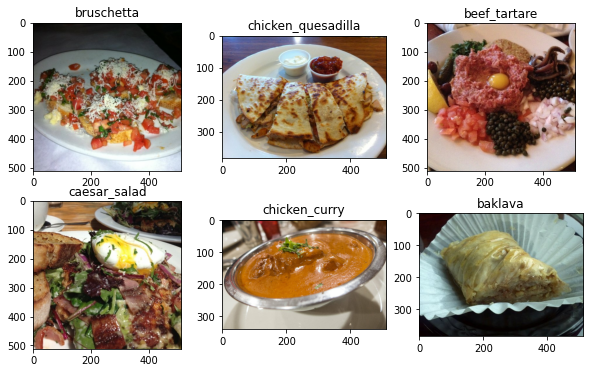

In [5]:
plt.figure(figsize=(10, 6))
for i, (image, label) in enumerate(train_ds.take(6)):
    ax = plt.subplot(2, 3, i + 1)
    plt.imshow(image)
    plt.title(CLASS_NAMES[label])
    #plt.axis("off")

## Resize and normalize

In [6]:
# Normalize the images
def norm(img, label):
  return tf.keras.applications.mobilenet_v2.preprocess_input(tf.cast(img, tf.float32)), label

train_ds = train_ds.map(norm)
validation_ds = validation_ds.map(norm)
test_ds = test_ds.map(norm)

In [7]:
# TODO Resize the images in the training, validation and test set
def resize(img, label):
  return tf.image.resize(img[tf.newaxis], [224, 224])[0], label

train_ds = train_ds.map(resize)
validation_ds = validation_ds.map(resize)
test_ds = test_ds.map(resize)

In [8]:
# One hot encode the labels
def one_hot(img, label):
  return img, tf.one_hot([label], N_CLASSES)[0]

train_ds = train_ds.map(one_hot)
validation_ds = validation_ds.map(one_hot)
test_ds = test_ds.map(one_hot)

In [9]:
# batch dataset
batch_size = 32

train_ds = train_ds.batch(batch_size)
validation_ds = validation_ds.batch(batch_size)
test_ds = test_ds.batch(batch_size)

In [10]:
# repeat train and valdatasets

train_ds = train_ds.repeat()
validation_ds = validation_ds.repeat()

In [11]:
steps_per_epoch = (101 * N_CLASSES) // batch_size

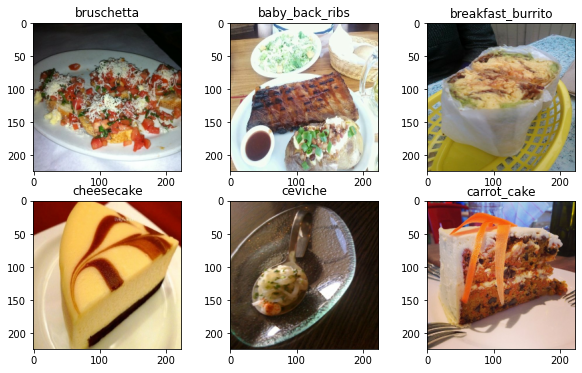

In [12]:
plt.figure(figsize=(10, 6))
for i, (image, label) in enumerate(train_ds.take(6)):
    image = image.numpy()
    ax = plt.subplot(2, 3, i + 1)
    plt.imshow((image[0] - image[0].min()) / (image[0].max() - image[0].min()))
    plt.title(CLASS_NAMES[np.argmax(label[0])])
    #plt.axis("off")

## Data-Augmentation

In [13]:
# Optional define/implements data-augmentation

## Training
### Step 1: Only train the head of the network

In [14]:
%%time
# Load the pretrained model from the available models: https://keras.io/api/applications/#available-models. 
# Load the imagenet weights but do not include the ImageNet classifier at the top.
#
# Tip, don't choose models that are too big because the training could take hours. 
# A model like mobilenet is more than enough for the exercise.

base_model = tf.keras.applications.MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3), pooling="max") # using max pooling over the channel dimension

# Freeze the base_model
base_model.trainable = False

# Create the model structure
inputs = tf.keras.layers.Input(shape=(224, 224, 3))
features = base_model(inputs)
outputs = tf.keras.layers.Dense(units=N_CLASSES, activation="softmax")(features)

model1 = keras.Model(inputs, outputs)

model1.summary()

9412608/9406464 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 20)                25620     
Total params: 2,283,604
Trainable params: 25,620
Non-trainable params: 2,257,984
_________________________________________________________________
CPU times: user 1.42 s, sys: 54.5 ms, total: 1.47 s
Wall time: 1.73 s


In [15]:
%%time

# Compile the model with your optimizer, your loss and your metrics
model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss="categorical_crossentropy", metrics="accuracy")

# Optional: Define and use callbacks
checkpoint = tf.keras.callbacks.ModelCheckpoint('model-{epoch:03d}.h5', verbose=1, monitor='val_accuracy',save_best_only=True, mode="auto")

step1_history = model1.fit(train_ds, steps_per_epoch=steps_per_epoch, validation_data=validation_ds, validation_steps=steps_per_epoch // 10, callbacks=[checkpoint], epochs=30) # You should us a smaller learning rate: 1e-6

Epoch 1/30
63/63 [==============================] - 64s 460ms/step - loss: 5.7488 - accuracy: 0.1182 - val_loss: 3.0387 - val_accuracy: 0.3750

Epoch 00001: val_accuracy improved from -inf to 0.37500, saving model to model-001.h5
Epoch 2/30
63/63 [==============================] - 23s 375ms/step - loss: 2.8023 - accuracy: 0.3630 - val_loss: 2.4325 - val_accuracy: 0.4479

Epoch 00002: val_accuracy improved from 0.37500 to 0.44792, saving model to model-002.h5
Epoch 3/30
63/63 [==============================] - 23s 378ms/step - loss: 2.5672 - accuracy: 0.3993 - val_loss: 1.7737 - val_accuracy: 0.5729

Epoch 00003: val_accuracy improved from 0.44792 to 0.57292, saving model to model-003.h5
Epoch 4/30
63/63 [==============================] - 23s 368ms/step - loss: 2.2712 - accuracy: 0.4739 - val_loss: 1.8088 - val_accuracy: 0.5521

Epoch 00004: val_accuracy did not improve from 0.57292
Epoch 5/30
63/63 [==============================] - 22s 354ms/step - loss: 1.9760 - accuracy: 0.5477 - va

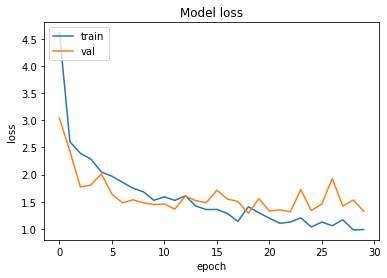

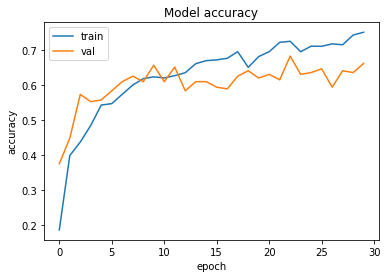

In [16]:
def plot_history(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric])
    plt.title('Model '+metric)
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
plot_history(step1_history, 'loss')
plot_history(step1_history, 'accuracy')

The model seems to converge with high bias and low variance. Adding more hidden layers might help to reduce the bias problem.

### Step 2: Fine-Tune the whole model

In [17]:
%%time

base_model = tf.keras.applications.MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3), pooling="max") # using max pooling over the channel dimension

# Freeze the base_model
base_model.trainable = True

# Create the model structure
inputs = tf.keras.layers.Input(shape=(224, 224, 3))
features = base_model(inputs)
outputs = tf.keras.layers.Dense(units=N_CLASSES, activation="softmax")(features)

model2 = keras.Model(inputs, outputs)

model2.summary()

# Compile the model again
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6), loss="categorical_crossentropy", metrics="accuracy")

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 1280)              2257984   
_________________________________________________________________
dense_1 (Dense)              (None, 20)                25620     
Total params: 2,283,604
Trainable params: 2,249,492
Non-trainable params: 34,112
_________________________________________________________________
CPU times: user 1.35 s, sys: 24.5 ms, total: 1.37 s
Wall time: 1.58 s


In [18]:
# Retrain the model
step2_history = model2.fit(train_ds, steps_per_epoch=steps_per_epoch, validation_data=validation_ds, validation_steps=steps_per_epoch // 10, callbacks=[checkpoint], epochs=300) # You should us a smaller learning rate: 1e-6

Epoch 1/300
63/63 [==============================] - 25s 309ms/step - loss: 8.6799 - accuracy: 0.0483 - val_loss: 8.8587 - val_accuracy: 0.0469

Epoch 00001: val_accuracy did not improve from 0.68229
Epoch 2/300
63/63 [==============================] - 19s 300ms/step - loss: 8.6054 - accuracy: 0.0492 - val_loss: 8.7335 - val_accuracy: 0.0521

Epoch 00002: val_accuracy did not improve from 0.68229
Epoch 3/300
63/63 [==============================] - 19s 300ms/step - loss: 8.1981 - accuracy: 0.0521 - val_loss: 8.5997 - val_accuracy: 0.0521

Epoch 00003: val_accuracy did not improve from 0.68229
Epoch 4/300
63/63 [==============================] - 19s 307ms/step - loss: 8.2432 - accuracy: 0.0406 - val_loss: 8.4889 - val_accuracy: 0.0469

Epoch 00004: val_accuracy did not improve from 0.68229
Epoch 5/300
63/63 [==============================] - 19s 307ms/step - loss: 7.9171 - accuracy: 0.0717 - val_loss: 8.3856 - val_accuracy: 0.0469

Epoch 00005: val_accuracy did not improve from 0.68229


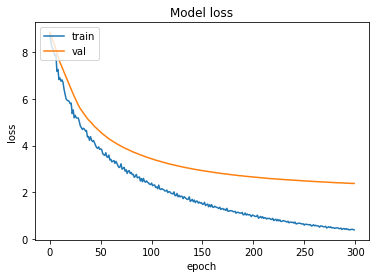

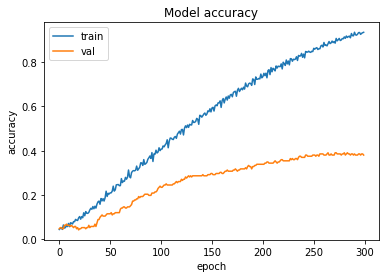

In [19]:
plot_history(step2_history, 'loss')
plot_history(step2_history, 'accuracy')

When allowing the parameters of the base model to be modified as well, we add a large amount of capacity to the model which leads to a strong overfit. Now the model experiences high variance and rather low bias (the train accuracy has not converged yet). Data augmentation, Dropout or weight regularizers could help to adress those problems.

## Test the fine-tuned model

In [20]:
%%time
# Predict the test set
y_pred = model1.predict(test_ds, verbose=1)

# De-encode the onehot encoded labels
y_pred = np.argmax(y_pred, axis=1)
y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for x, y in test_ds], axis=0)

78/78 [==============================] - 32s 377ms/step
CPU times: user 56.4 s, sys: 4.04 s, total: 1min
Wall time: 47 s


In [21]:
%%time

# Accuracy
acc = accuracy_score(y_true, y_pred)
print("Accuracy:", acc)

Accuracy: 0.6214802896218825
CPU times: user 2.74 ms, sys: 88 µs, total: 2.83 ms
Wall time: 9.2 ms


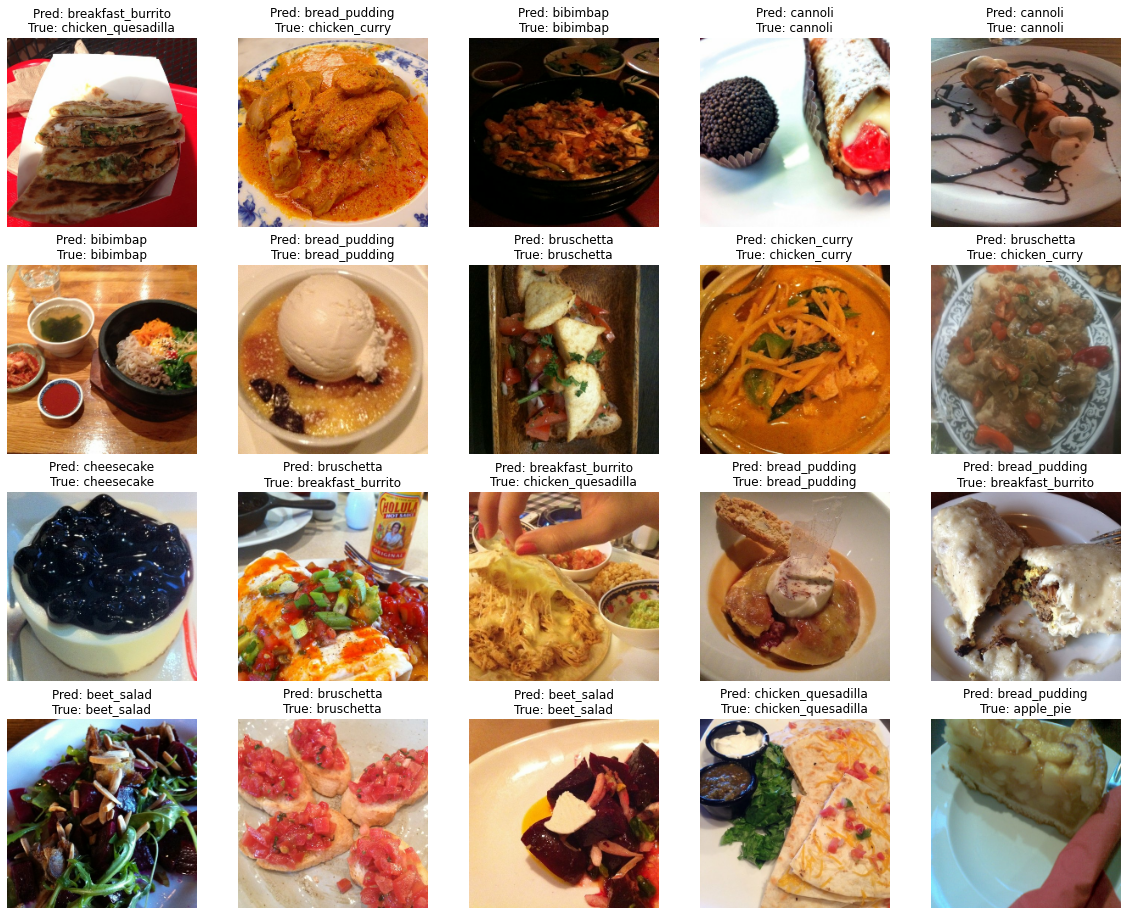

In [22]:
def show_images_prediction(page=0):
    test_examples = (np.concatenate([x.numpy() for x, y in test_ds])+1)/2*255
    test_examples = test_examples.astype("uint32")
    
    page_size = 20
    nrows = 4
    ncols = 5
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 12))
    fig.set_size_inches(20, 16)

    start_i = page * page_size
    for i, ax in enumerate(axes.flat):
        im = ax.imshow(test_examples[i+start_i])
        ax.set_axis_off()
        ax.set_title("Pred: "+CLASS_NAMES[y_pred[i+start_i]]+"\nTrue: "+CLASS_NAMES[y_true[i+start_i]])
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])

    plt.show()
show_images_prediction(2)